 Iter          Cost_f           Error
    0    3.812664e-02    5.299328e-01
   85    1.107302e+00    9.088746e-13
 Iter          Cost_f           Error
    0    5.510251e-01    7.713935e-03
   76    1.347281e+00    9.097802e-13
 Iter          Cost_f           Error
    0    6.824443e-01    5.766675e-03
   73    1.526879e+00    7.180606e-13
 Iter          Cost_f           Error
    0    7.816416e-01    4.279722e-03
   76    1.662464e+00    9.166487e-13
 Iter          Cost_f           Error
    0    8.569461e-01    3.141520e-03
   75    1.765614e+00    5.549404e-13
 Iter          Cost_f           Error
    0    9.144171e-01    2.308473e-03
   86    1.844622e+00    9.850072e-13
 Iter          Cost_f           Error
    0    9.584626e-01    1.692542e-03
   80    1.905466e+00    6.187124e-13
 Iter          Cost_f           Error
    0    9.923521e-01    1.236138e-03
   76    1.952547e+00    9.121168e-13
 Iter          Cost_f           Error
    0    1.018533e+00    9.113922e-04
   77    1.9

G_inf: 1.0  G: [1.0]
tau: [1]  eta: [1.0]


[np.float64(0.030092901039801893),
 np.float64(0.0343812557602911),
 np.float64(0.03754300247269152),
 np.float64(0.03991567666902096),
 np.float64(0.04171563708305511),
 np.float64(0.04309094174405238),
 np.float64(0.04414699366141055),
 np.float64(0.04496077068177141),
 np.float64(0.045589471651106446),
 np.float64(0.04607611612023636),
 np.float64(0.04645334168481716),
 np.float64(0.04674606735156101),
 np.float64(0.04697340887413104),
 np.float64(0.04715008221190009),
 np.float64(0.04728744657424502),
 np.float64(0.04739428799215573),
 np.float64(0.04747741282268906),
 np.float64(0.04754210013248663),
 np.float64(0.0475924481919075),
 np.float64(0.047631640860079295)]

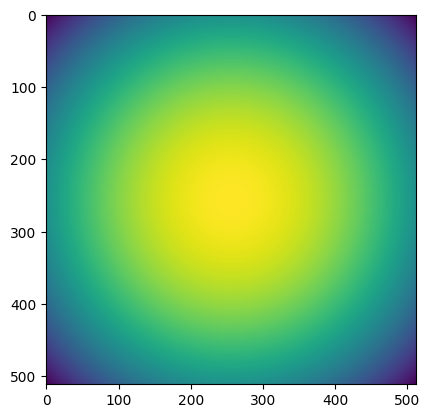

In [11]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

# parallel computation
tm.initialize(8)

# discretization
n = 512 #[256, 512, 1024]

##time
t0 = 0
t1 = 10 

time_steps = 20
dt = (t1 - t0)/time_steps


##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [model.mu]
characteristic_time = [1] 


#We apply analytical solution in Hertz contact
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#solver.solve(p_target)

#solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)


for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas.append(np.mean(model.traction > 0)*L**2)

G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5

##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

for t in np.arange(t0, t1, dt):        
    Ac_Johnson_ref.append((3/8 * Radius * W * (1/g_1 + 1/g_2*(1-np.exp(-t/tau_c[0]))))**(2/3)*np.pi)

tau_c
Ac_Johnson_ref  

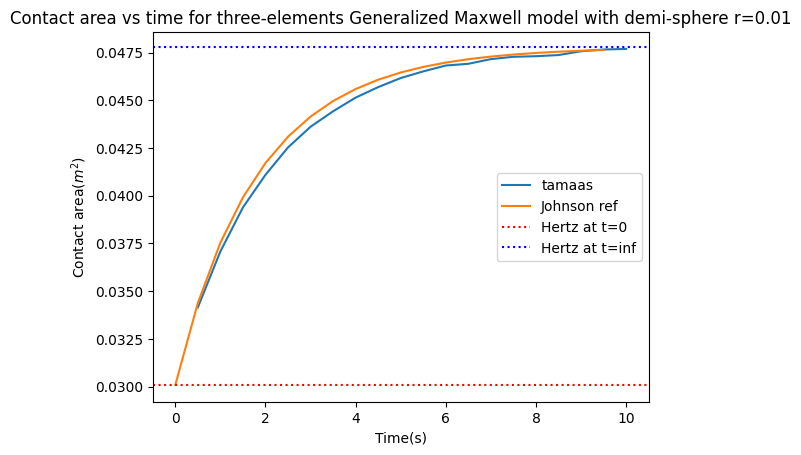

In [10]:
plt.plot(np.arange(t0, t1, dt)+dt, Ac_tamaas)
plt.plot(np.arange(t0, t1, dt), Ac_Johnson_ref)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.legend(["tamaas","Johnson ref", "Hertz at t=0", "Hertz at t=inf"])
#define a title that can read parameter tau_0
plt.title("Contact area vs time for three-elements Generalized Maxwell model with demi-sphere r=0.01")
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()

In [12]:
Ac_tamaas

[np.float64(0.034152984619140625),
 np.float64(0.037082672119140625),
 np.float64(0.039386749267578125),
 np.float64(0.041095733642578125),
 np.float64(0.042530059814453125),
 np.float64(0.043613433837890625),
 np.float64(0.044422149658203125),
 np.float64(0.045139312744140625),
 np.float64(0.045688629150390625),
 np.float64(0.046161651611328125),
 np.float64(0.046512603759765625),
 np.float64(0.046817779541015625),
 np.float64(0.046909332275390625),
 np.float64(0.047153472900390625),
 np.float64(0.047275543212890625),
 np.float64(0.047306060791015625),
 np.float64(0.047367095947265625),
 np.float64(0.047565460205078125),
 np.float64(0.047657012939453125),
 np.float64(0.047687530517578125)]